[AlexNet Paper](./NIPS-2012-imagenet-classification-with-deep-convolutional-neural-networks-Paper.pdf)

![image-20250622110954912](http://assets.hypervoid.top/img/2025/06/22/image-20250622110954912-74c6.png)

![image-20250622162539576](http://assets.hypervoid.top/img/2025/06/22/image-20250622162539576-46bc.png)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
batch_size = 192
num_epoch = 50
num_class = 10 # cifar10
lr = 1e-3
loss_func = nn.CrossEntropyLoss()
torch.autograd.set_detect_anomaly(True)

In [ ]:
import torchvision as tv
from torchvision import transforms


transform = transforms.Compose([
    transforms.Resize((227,227)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = tv.datasets.cifar.CIFAR10("./cifar10_dataset",train=True,  download=True, transform=transform)
test_data = tv.datasets.cifar.CIFAR10("./cifar10_dataset",train=False,  download=True, transform=transform)

train_iter = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

for x, y in train_data:
    print(x.shape, y)
    break

Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 227, 227]) 6


In [ ]:
from torch import Tensor


class AlexNet(nn.Module):
    def __init__(self, num_feats=1000):
        super(AlexNet, self).__init__()
        self.num_feats = num_feats
        self.conv1 = nn.Sequential(
            # 输入: (N, 3, 227, 227)
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),
            # 输出 （N, 96, 55, 55）
            nn.BatchNorm2d(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (N, 96, 27, 27)
        )
        self.conv2 = nn.Sequential(
            # 输入: (N, 96, 27, 27)
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2),
            # 输出 (N, 256, 13, 13)
            nn.BatchNorm2d(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (N, 256, 13, 13)
        )
        self.conv3 = nn.Sequential(
            # 输入: (N, 256, 13, 13)
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding='same'),
            nn.BatchNorm2d(),
            nn.ReLU(),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, padding='same'),
            nn.BatchNorm2d(),
            nn.ReLU(),
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding='same'),
            nn.BatchNorm2d(),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # 输出 (N, 256, 6, 6)
        )
        self.encoder = nn.Sequential(
            self.conv1,
            self.conv2,
            self.conv3,
            self.conv4,
            self.conv5,
        )
        # 输出 (N, 256, 6, 6)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.5, ),
            nn.Linear(in_features=(256 * 6 * 6), out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5, ),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=self.num_feats),
        )
    def forward(self, x:Tensor):
        enc = self.encoder(x)
        return self.classifier(enc)


In [65]:
from torchsummary import summary

summary(AlexNet(10))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       34,944
|    └─ReLU: 2-2                         --
|    └─MaxPool2d: 2-3                    --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-4                       614,656
|    └─ReLU: 2-5                         --
|    └─MaxPool2d: 2-6                    --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-7                       885,120
|    └─ReLU: 2-8                         --
├─Sequential: 1-4                        --
|    └─Conv2d: 2-9                       1,327,488
|    └─ReLU: 2-10                        --
├─Sequential: 1-5                        --
|    └─Conv2d: 2-11                      884,992
|    └─ReLU: 2-12                        --
|    └─MaxPool2d: 2-13                   --
├─Sequential: 1-6                        --
|    └─Sequential: 2-14                  (recursive)
|    |    └─Conv2d: 3-1             

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       34,944
|    └─ReLU: 2-2                         --
|    └─MaxPool2d: 2-3                    --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-4                       614,656
|    └─ReLU: 2-5                         --
|    └─MaxPool2d: 2-6                    --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-7                       885,120
|    └─ReLU: 2-8                         --
├─Sequential: 1-4                        --
|    └─Conv2d: 2-9                       1,327,488
|    └─ReLU: 2-10                        --
├─Sequential: 1-5                        --
|    └─Conv2d: 2-11                      884,992
|    └─ReLU: 2-12                        --
|    └─MaxPool2d: 2-13                   --
├─Sequential: 1-6                        --
|    └─Sequential: 2-14                  (recursive)
|    |    └─Conv2d: 3-1             

In [67]:
net = AlexNet(num_class).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

train_loss, test_loss, train_acc, test_acc = [], [], [], []

for epoch in range(num_epoch):
    net.train()
    train_loss_epoch, train_acc_epoch, img_cnt = 0, 0, 0
    for x, y in train_iter:
        x, y = x.to(device), y.to(device)
        pred: Tensor = net(x)
        los = loss_func(pred, y)
        los.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss_epoch += los.item()
        img_cnt += y.shape[0]
        train_acc_epoch += (pred.argmax(dim=1) == y).sum().item()
    train_loss_epoch /= img_cnt
    train_acc_epoch /= img_cnt
    train_loss.append(train_loss_epoch)
    train_acc.append(train_acc_epoch)
    # ------
    net.eval()
    test_loss_epoch, img_cnt, test_acc_epoch = 0, 0, 0
    with torch.no_grad():
        for x, y in test_iter:
            x, y = x.to(device), y.to(device)
            pred: Tensor = net(x)
            los = loss_func(pred, y)
            test_loss_epoch += los.item()
            test_acc_epoch += (pred.argmax(dim=1) == y).sum().item()
            img_cnt += y.shape[0]

    test_loss_epoch /= img_cnt
    test_acc_epoch /= img_cnt

    test_loss.append(test_loss_epoch)
    test_acc.append(test_acc_epoch)

    print(
        f"[{epoch+1:2d}/{num_epoch}]\t train_loss={train_loss_epoch:.4f}, test_loss={test_loss_epoch:.4f}, train_acc={train_acc_epoch:.4f} test_acc={test_acc_epoch:.4f}"
    )
    torch.save(net.state_dict(), f"alex_cifar10_{epoch+1:03d}.pth")

[ 1/50]	 train_loss=0.0116, test_loss=0.0105, train_acc=0.1535 test_acc=0.2654
[ 2/50]	 train_loss=0.0091, test_loss=0.0081, train_acc=0.3602 test_acc=0.4441
[ 3/50]	 train_loss=0.0079, test_loss=0.0073, train_acc=0.4492 test_acc=0.4999
[ 4/50]	 train_loss=0.0072, test_loss=0.0067, train_acc=0.5013 test_acc=0.5391
[ 5/50]	 train_loss=0.0067, test_loss=0.0063, train_acc=0.5360 test_acc=0.5699
[ 6/50]	 train_loss=0.0062, test_loss=0.0060, train_acc=0.5713 test_acc=0.5991
[ 7/50]	 train_loss=0.0059, test_loss=0.0054, train_acc=0.5969 test_acc=0.6370
[ 8/50]	 train_loss=0.0056, test_loss=0.0053, train_acc=0.6193 test_acc=0.6493
[ 9/50]	 train_loss=0.0053, test_loss=0.0051, train_acc=0.6374 test_acc=0.6656
[10/50]	 train_loss=0.0050, test_loss=0.0050, train_acc=0.6577 test_acc=0.6712
[11/50]	 train_loss=0.0048, test_loss=0.0049, train_acc=0.6683 test_acc=0.6784
[12/50]	 train_loss=0.0046, test_loss=0.0049, train_acc=0.6832 test_acc=0.6750
[13/50]	 train_loss=0.0044, test_loss=0.0046, train_

C:\Users\jcheng\AppData\Local\Temp\ipykernel_14952\3188439808.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("alex_cifar10_050.pth"))


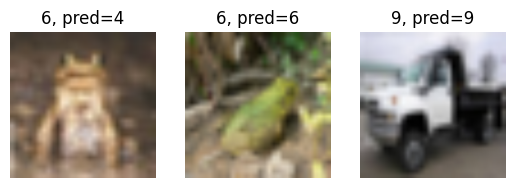

In [8]:
net = AlexNet(num_class).to(device)
net.load_state_dict(torch.load("alex_cifar10_050.pth"))
net.eval()
vis_data = tv.datasets.CIFAR10("./cifar10_dataset", train=False, transform=transform)
vis_iter = torch.utils.data.DataLoader(vis_data, batch_size=1, shuffle=True)

_, ax = plt.subplots(1, 3)
for i, (x, y) in enumerate(vis_iter):
    if i >= 3:
        break
    x: Tensor = x.to(device)
    y: Tensor = y.to(device)
    pred: Tensor = net(x).argmax()
    x.squeeze_()
    y.squeeze_()
    pred.squeeze_()
    ax[i].set_title(f"{y.data}, pred={pred.data}")
    ax[i].imshow(x.cpu().permute(1, 2, 0).numpy())
    ax[i].axis('off')
plt.show()